<a href="https://colab.research.google.com/github/renataa21/Animal_Pytorch_Classification/blob/main/Animal_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision import models
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('new')

Mounted at new


In [3]:
#определим устройство, где проводить вычисления (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
#путь до датасета
# зададим какие преобразования необходимо сделать с каждым изображением
transform = transforms.Compose(
    [transforms.Resize((250,250)),  #изменим размер изображений
     #transforms.CenterCrop(64),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     #transforms.RandomRotate(10),
     transforms.ToTensor(),   #переведем в формат который необходим нейронной сети - тензор
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) # проведем нормализацию изображения

#загружаем тренировочный и тестовый датасеты
trainset = torchvision.datasets.ImageFolder(("/content/new/MyDrive/new/afhq/train"), transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, num_workers=2, shuffle=True)

testset = torchvision.datasets.ImageFolder(("/content/new/MyDrive/new/afhq/val"), transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, num_workers=2, shuffle=True)

In [5]:
print(trainset.classes)
print(testset.classes)
trainloader.dataset

['cat', 'dog', 'wild']
['cat', 'dog', 'wild']


Dataset ImageFolder
    Number of datapoints: 14630
    Root location: /content/new/MyDrive/new/afhq/train
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [23]:
#функция для вывода изображений
def image_shower(images, labels, n=6):
    plt.figure(figsize=(20, 20))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))

#имена классов
classes = ('cat', 'dog', 'wild')

Real Labels:    dog   cat   dog   cat


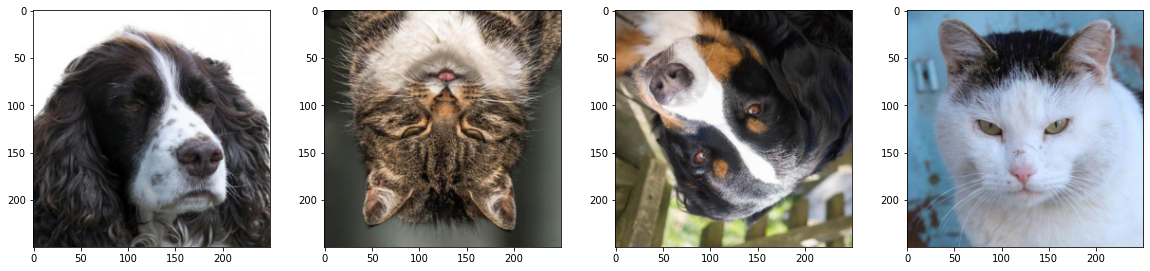

In [7]:
#Проверим как работает наш загрузчик и посмотрим на парочку изображений
images, labels = next(iter(trainloader))
image_shower(images, labels)

In [14]:
class MyCNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.relu = nn.ReLU()
        self.normal = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.drop2d = nn.Dropout2d(0.2)
        self.liner = nn.Linear(238144, 64)
        self.drop = nn.Dropout(0.1)
        self.liner2 = nn.Linear(64, 3)
        self.soft = nn.Softmax(0)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.normal(x)
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.drop2d(x)
        x = self.maxpool(x)     
        x = x.flatten(1)
        x = self.liner(x)
        x = self.drop(x)
        x = self.soft(self.liner2(x))
        
        return x

In [15]:
model = MyCNNClassifier()
print(model)

MyCNNClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (normal): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2d): Dropout2d(p=0.2, inplace=False)
  (liner): Linear(in_features=238144, out_features=64, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (liner2): Linear(in_features=64, out_features=3, bias=True)
  (soft): Softmax(dim=0)
)


In [ ]:
# def print_size_of_model(model):
#     torch.save(model.state_dict(), "temp.p")
#     print('Size (MB):', os.path.getsize("temp.p")/1e6)
#     os.remove('temp.p')

In [13]:
#посчитаем точность работы нашего классификатора
def accur():
    correct = 0
    total = 0
    with torch.no_grad():
        #переводим модель в режим инференса
        model.eval()
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            #получаем наши предсказания
            _, predicted = torch.max(outputs.data, 1)
            #посчитаем общее количество картинок
            total += labels.size(0)
            #посчитаем количество точно классифицированных картинок
            correct += (predicted == labels).sum().item()
    print("Accuracy: %d" %(100 * correct/total))
    return 100 * correct/total


In [16]:
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
max_acc = 0
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
accuracy_hist = []
loss_hist = []


# итерируемся
for epoch in tqdm(range(15)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
         # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()

        if i % 33 == 32:
            print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, running_loss / len(trainloader)))
            loss_hist.append(running_loss/ len(trainloader))
            running_loss = 0.0
            acc = accur()
            accuracy_hist.append(acc)
            if max_acc < acc:
                max_acc = acc
                torch.save(model, '/content/sample_data/Animal.pt')
                torch.save(model.state_dict(), '/content/sample_data/Animal-parameters3.pt')

print('Обучение закончено')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/458 [00:00<?, ?it/s]

[1,    33] loss: 0.0776
Accuracy: 49
[1,    66] loss: 0.0772
Accuracy: 50
[1,    99] loss: 0.0772
Accuracy: 55
[1,   132] loss: 0.0760
Accuracy: 58
[1,   165] loss: 0.0758
Accuracy: 59
[1,   198] loss: 0.0757
Accuracy: 61
[1,   231] loss: 0.0756
Accuracy: 64
[1,   264] loss: 0.0755
Accuracy: 60
[1,   297] loss: 0.0756
Accuracy: 66
[1,   330] loss: 0.0754
Accuracy: 66
[1,   363] loss: 0.0757
Accuracy: 69
[1,   396] loss: 0.0755
Accuracy: 68
[1,   429] loss: 0.0753
Accuracy: 70


  0%|          | 0/458 [00:00<?, ?it/s]

[2,    33] loss: 0.0756
Accuracy: 71
[2,    66] loss: 0.0755
Accuracy: 70
[2,    99] loss: 0.0754
Accuracy: 69
[2,   132] loss: 0.0753
Accuracy: 68
[2,   165] loss: 0.0753
Accuracy: 70
[2,   198] loss: 0.0754
Accuracy: 67
[2,   231] loss: 0.0753
Accuracy: 69
[2,   264] loss: 0.0753
Accuracy: 72
[2,   297] loss: 0.0753
Accuracy: 72
[2,   330] loss: 0.0753
Accuracy: 71
[2,   363] loss: 0.0753
Accuracy: 73
[2,   396] loss: 0.0753
Accuracy: 71
[2,   429] loss: 0.0753
Accuracy: 72


  0%|          | 0/458 [00:00<?, ?it/s]

[3,    33] loss: 0.0753
Accuracy: 71
[3,    66] loss: 0.0754
Accuracy: 71
[3,    99] loss: 0.0752
Accuracy: 72
[3,   132] loss: 0.0753
Accuracy: 72
[3,   165] loss: 0.0754
Accuracy: 72
[3,   198] loss: 0.0752
Accuracy: 73
[3,   231] loss: 0.0753
Accuracy: 75
[3,   264] loss: 0.0754
Accuracy: 75
[3,   297] loss: 0.0752
Accuracy: 77
[3,   330] loss: 0.0753
Accuracy: 75
[3,   363] loss: 0.0751
Accuracy: 78
[3,   396] loss: 0.0752
Accuracy: 77
[3,   429] loss: 0.0752
Accuracy: 78


  0%|          | 0/458 [00:00<?, ?it/s]

[4,    33] loss: 0.0752
Accuracy: 75
[4,    66] loss: 0.0753
Accuracy: 77
[4,    99] loss: 0.0753
Accuracy: 73
[4,   132] loss: 0.0752
Accuracy: 75
[4,   165] loss: 0.0752
Accuracy: 79
[4,   198] loss: 0.0752
Accuracy: 80
[4,   231] loss: 0.0752
Accuracy: 79
[4,   264] loss: 0.0753
Accuracy: 79
[4,   297] loss: 0.0752
Accuracy: 78
[4,   330] loss: 0.0752
Accuracy: 80
[4,   363] loss: 0.0752
Accuracy: 78
[4,   396] loss: 0.0752
Accuracy: 79
[4,   429] loss: 0.0752
Accuracy: 79


  0%|          | 0/458 [00:00<?, ?it/s]

[5,    33] loss: 0.0751
Accuracy: 81
[5,    66] loss: 0.0751
Accuracy: 75
[5,    99] loss: 0.0752
Accuracy: 77
[5,   132] loss: 0.0752
Accuracy: 79
[5,   165] loss: 0.0751
Accuracy: 81
[5,   198] loss: 0.0751
Accuracy: 80
[5,   231] loss: 0.0751
Accuracy: 83
[5,   264] loss: 0.0752
Accuracy: 81
[5,   297] loss: 0.0752
Accuracy: 83
[5,   330] loss: 0.0752
Accuracy: 78
[5,   363] loss: 0.0752
Accuracy: 79
[5,   396] loss: 0.0752
Accuracy: 80
[5,   429] loss: 0.0751
Accuracy: 78


  0%|          | 0/458 [00:00<?, ?it/s]

[6,    33] loss: 0.0751
Accuracy: 83
[6,    66] loss: 0.0751
Accuracy: 82
[6,    99] loss: 0.0751
Accuracy: 81
[6,   132] loss: 0.0751
Accuracy: 82
[6,   165] loss: 0.0751
Accuracy: 83
[6,   198] loss: 0.0751
Accuracy: 83
[6,   231] loss: 0.0751
Accuracy: 82
[6,   264] loss: 0.0752
Accuracy: 84
[6,   297] loss: 0.0751
Accuracy: 82
[6,   330] loss: 0.0751
Accuracy: 83
[6,   363] loss: 0.0751
Accuracy: 81
[6,   396] loss: 0.0751
Accuracy: 83
[6,   429] loss: 0.0751
Accuracy: 82


  0%|          | 0/458 [00:00<?, ?it/s]

[7,    33] loss: 0.0751
Accuracy: 83
[7,    66] loss: 0.0751
Accuracy: 81
[7,    99] loss: 0.0751
Accuracy: 81
[7,   132] loss: 0.0751
Accuracy: 80
[7,   165] loss: 0.0751
Accuracy: 86
[7,   198] loss: 0.0751
Accuracy: 83
[7,   231] loss: 0.0751
Accuracy: 85
[7,   264] loss: 0.0750
Accuracy: 86
[7,   297] loss: 0.0751
Accuracy: 86
[7,   330] loss: 0.0751
Accuracy: 82
[7,   363] loss: 0.0751
Accuracy: 84
[7,   396] loss: 0.0751
Accuracy: 85
[7,   429] loss: 0.0751
Accuracy: 86


  0%|          | 0/458 [00:00<?, ?it/s]

[8,    33] loss: 0.0752
Accuracy: 79
[8,    66] loss: 0.0752
Accuracy: 84
[8,    99] loss: 0.0751
Accuracy: 82
[8,   132] loss: 0.0751
Accuracy: 81
[8,   165] loss: 0.0751
Accuracy: 85
[8,   198] loss: 0.0751
Accuracy: 85
[8,   231] loss: 0.0751
Accuracy: 86
[8,   264] loss: 0.0751
Accuracy: 86
[8,   297] loss: 0.0751
Accuracy: 85
[8,   330] loss: 0.0751
Accuracy: 85
[8,   363] loss: 0.0750
Accuracy: 86
[8,   396] loss: 0.0751
Accuracy: 86
[8,   429] loss: 0.0751
Accuracy: 86


  0%|          | 0/458 [00:00<?, ?it/s]

[9,    33] loss: 0.0752
Accuracy: 78
[9,    66] loss: 0.0752
Accuracy: 80
[9,    99] loss: 0.0751
Accuracy: 83
[9,   132] loss: 0.0750
Accuracy: 85
[9,   165] loss: 0.0751
Accuracy: 86
[9,   198] loss: 0.0750
Accuracy: 87
[9,   231] loss: 0.0751
Accuracy: 86
[9,   264] loss: 0.0751
Accuracy: 85
[9,   297] loss: 0.0751
Accuracy: 86
[9,   330] loss: 0.0751
Accuracy: 86
[9,   363] loss: 0.0750
Accuracy: 87
[9,   396] loss: 0.0750
Accuracy: 88
[9,   429] loss: 0.0750
Accuracy: 85


  0%|          | 0/458 [00:00<?, ?it/s]

[10,    33] loss: 0.0752
Accuracy: 84
[10,    66] loss: 0.0751
Accuracy: 83
[10,    99] loss: 0.0751
Accuracy: 85
[10,   132] loss: 0.0750
Accuracy: 86
[10,   165] loss: 0.0750
Accuracy: 88
[10,   198] loss: 0.0750
Accuracy: 87
[10,   231] loss: 0.0751
Accuracy: 87
[10,   264] loss: 0.0751
Accuracy: 87
[10,   297] loss: 0.0750
Accuracy: 88
[10,   330] loss: 0.0750
Accuracy: 88
[10,   363] loss: 0.0750
Accuracy: 88
[10,   396] loss: 0.0751
Accuracy: 88
[10,   429] loss: 0.0750
Accuracy: 89


  0%|          | 0/458 [00:00<?, ?it/s]

[11,    33] loss: 0.0750
Accuracy: 87
[11,    66] loss: 0.0751
Accuracy: 85
[11,    99] loss: 0.0750
Accuracy: 88
[11,   132] loss: 0.0750
Accuracy: 88
[11,   165] loss: 0.0750
Accuracy: 88
[11,   198] loss: 0.0750
Accuracy: 88
[11,   231] loss: 0.0750
Accuracy: 88
[11,   264] loss: 0.0750
Accuracy: 87
[11,   297] loss: 0.0750
Accuracy: 89
[11,   330] loss: 0.0750
Accuracy: 88
[11,   363] loss: 0.0750
Accuracy: 88
[11,   396] loss: 0.0750
Accuracy: 90
[11,   429] loss: 0.0750
Accuracy: 88


  0%|          | 0/458 [00:00<?, ?it/s]

[12,    33] loss: 0.0750
Accuracy: 89
[12,    66] loss: 0.0750
Accuracy: 88
[12,    99] loss: 0.0750
Accuracy: 89
[12,   132] loss: 0.0750
Accuracy: 88
[12,   165] loss: 0.0750
Accuracy: 89
[12,   198] loss: 0.0750
Accuracy: 89
[12,   231] loss: 0.0750
Accuracy: 89
[12,   264] loss: 0.0750
Accuracy: 89
[12,   297] loss: 0.0750
Accuracy: 89
[12,   330] loss: 0.0750
Accuracy: 90
[12,   363] loss: 0.0750
Accuracy: 88
[12,   396] loss: 0.0750
Accuracy: 89
[12,   429] loss: 0.0750
Accuracy: 88


  0%|          | 0/458 [00:00<?, ?it/s]

[13,    33] loss: 0.0750
Accuracy: 88
[13,    66] loss: 0.0750
Accuracy: 89
[13,    99] loss: 0.0750
Accuracy: 89
[13,   132] loss: 0.0750
Accuracy: 89
[13,   165] loss: 0.0750
Accuracy: 90
[13,   198] loss: 0.0750
Accuracy: 90
[13,   231] loss: 0.0750
Accuracy: 89
[13,   264] loss: 0.0750
Accuracy: 91
[13,   297] loss: 0.0749
Accuracy: 89
[13,   330] loss: 0.0750
Accuracy: 90
[13,   363] loss: 0.0750
Accuracy: 89
[13,   396] loss: 0.0750
Accuracy: 90
[13,   429] loss: 0.0749
Accuracy: 90


  0%|          | 0/458 [00:00<?, ?it/s]

[14,    33] loss: 0.0750
Accuracy: 90
[14,    66] loss: 0.0750
Accuracy: 89
[14,    99] loss: 0.0750
Accuracy: 90
[14,   132] loss: 0.0750
Accuracy: 88
[14,   165] loss: 0.0750
Accuracy: 89
[14,   198] loss: 0.0750
Accuracy: 89
[14,   231] loss: 0.0750
Accuracy: 89
[14,   264] loss: 0.0750
Accuracy: 90
[14,   297] loss: 0.0750
Accuracy: 90
[14,   330] loss: 0.0749
Accuracy: 90
[14,   363] loss: 0.0749
Accuracy: 90
[14,   396] loss: 0.0749
Accuracy: 90
[14,   429] loss: 0.0750
Accuracy: 90


  0%|          | 0/458 [00:00<?, ?it/s]

[15,    33] loss: 0.0750
Accuracy: 89
[15,    66] loss: 0.0750
Accuracy: 90
[15,    99] loss: 0.0749
Accuracy: 90
[15,   132] loss: 0.0749
Accuracy: 90
[15,   165] loss: 0.0750
Accuracy: 91
[15,   198] loss: 0.0750
Accuracy: 91
[15,   231] loss: 0.0750
Accuracy: 90
[15,   264] loss: 0.0749
Accuracy: 90
[15,   297] loss: 0.0750
Accuracy: 92
[15,   330] loss: 0.0749
Accuracy: 90
[15,   363] loss: 0.0749
Accuracy: 90
[15,   396] loss: 0.0749
Accuracy: 90
[15,   429] loss: 0.0750
Accuracy: 90
Обучение закончено


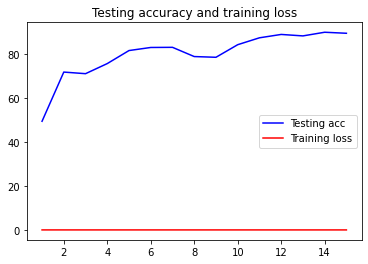

In [42]:
epochs = range(1, 16)

plt.plot(epochs, accuracy_hist[::13], 'b', label='Testing acc')
plt.plot(epochs, loss_hist[::13], 'r', label='Training loss')
plt.title('Testing accuracy and training loss')
plt.legend()
# plt.figure()
plt.show()

In [38]:
195/15

13.0

In [39]:
len(accuracy_hist[::13])

15

In [18]:
model = torch.load("/content/sample_data/Animal.pt")

In [19]:
model.to(device)

MyCNNClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (normal): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2d): Dropout2d(p=0.2, inplace=False)
  (liner): Linear(in_features=238144, out_features=64, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (liner2): Linear(in_features=64, out_features=3, bias=True)
  (soft): Softmax(dim=0)
)

In [20]:
pred = []
real = []
value = 0
with torch.no_grad():
    #переводим модель в режим инференса
    model.eval()
    for data in testloader:

        images, labels = data
        y_pred = model(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        pred.append(predicted)
        real.append(labels)
        value += len(predicted)

    
print(value)
print(classification_report(labels, predicted.cpu()))

1500
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.91      0.95        11
           2       1.00      1.00      1.00        12

    accuracy                           0.96        28
   macro avg       0.94      0.97      0.95        28
weighted avg       0.97      0.96      0.97        28



In [21]:
correct = 0
total = 0
with torch.no_grad():
    #переводим модель в режим инференса
    model.eval()
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        #получаем наши предсказания
        _, predicted = torch.max(outputs.data, 1)
        #посчитаем общее количество картинок
        total += labels.size(0)
        #посчитаем количество точно классифицированных картинок
        correct += (predicted == labels).sum().item()
print("Accuracy: %d" %(100 * correct/total))

Accuracy: 91


Real Labels:    cat  wild   cat  wild   dog   cat
Predicted:    cat  wild   cat  wild   dog   cat


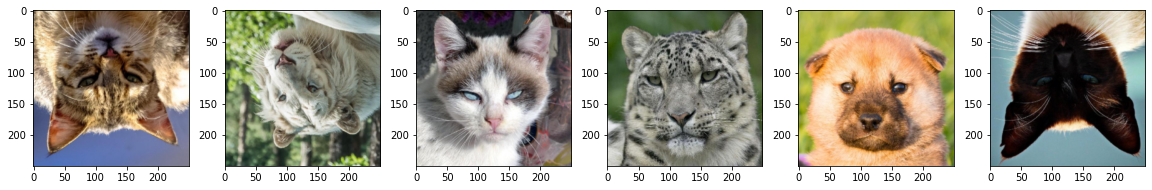

In [24]:
images, labels = next(iter(trainloader))
image_shower(images, labels)

outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)  # проверить без макс

print("Predicted: ", " ".join("%5s" %classes[predict] for predict in predicted[:6]))